In [1]:
import os 
import re
import time
import gzip
import shutil 

import requests 
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import numpy as np

import geopandas as gpd 
import rasterio
from rasterio.mask import mask 


import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('seaborn-v0_8-whitegrid') 

#---------Time Series--------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from scipy.stats import gamma # For the 'True' SPI

#---------Machine Learning---------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

#---------Deep Learning------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
CHIRPS_URL = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/africa_monthly/tifs/"
CHIRPS_DIR_GZ = "chirps_raw_gz"
os.makedirs(CHIRPS_DIR_GZ, exist_ok= True)
MAx_WORKERS_DOWNLOAD = 10

def download_chirps_data(url, filepath):
    filename = os.path.basename(filepath)

    if os.path.exists(filepath):
        return f'{filepath}: already exists'
    
    try :
        response =requests.get(url, timeout= 30)
        response.raise_for_status()
        with open (filepath, 'wb') as f:
            f.write(response.content)
        return f'{filename}: download successful'
    except requests.exceptions.RequestException as e:
        return f'{filename}: download failed - {e}'
    

if True:
    print('starting CHIRPS data download...')


dates = pd.date_range(start='1981-01', end='2024-12', freq='MS')

tasks_to_run = []
for date in dates:
    date_str = date.strftime('%Y.%m')
    filename_gz = f'chirps-v2.0.{date_str}.tif.gz'
    url = CHIRPS_URL + filename_gz
    filepath_gz = os.path.join(CHIRPS_DIR_GZ, filename_gz)
    tasks_to_run.append((url, filepath_gz))


start_time = time.time()
results_log = []

with ThreadPoolExecutor(max_workers=MAx_WORKERS_DOWNLOAD) as executor:
    futures = {executor.submit(download_chirps_data, url, filepath): (url, filepath) for url, filepath in tasks_to_run}


    for i, future in enumerate(as_completed(futures)):
        results_log.append(future.result())
        if (i+1) % 100 == 0:
            print(f'{i+1}/ {len(tasks_to_run)} files processed...')

end_time = time.time()
print(f'Download completed in {end_time - start_time:.2f} seconds.')


starting CHIRPS data download...
100/ 528 files processed...
200/ 528 files processed...
300/ 528 files processed...
400/ 528 files processed...
500/ 528 files processed...
Download completed in 774.27 seconds.


In [2]:
CHIRPS_DIR_GZ = "chirps_raw_gz"
CHIRPS_DIR_TIF = "chirps_raw_tif"
os.makedirs(CHIRPS_DIR_TIF, exist_ok=True)
MAx_WORKERS_DECOMPRESS = 10


def decompress_gz_file(gz_path):
    filename_gz = os.path.basename(gz_path)
    filename_tif = filename_gz[:-3] # Remove .gz extension
    tif_path = os.path.join(CHIRPS_DIR_TIF, filename_tif)

    if os.path.exists(tif_path):
        return f'{tif_path}: already exists'
    

    try:
        with gzip.open(gz_path, 'rb') as f_in:
            with open(tif_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        os.remove(gz_path) # Remove the .gz file after decompression
        return f'{filename_tif}: decompression successful'
    
    except Exception as e:
        return f'{filename_tif}: decompression failed - {e}'
    

if True:
    print('starting CHIRPS data decompression...')

    gz_file =  [os.path.join(CHIRPS_DIR_GZ, f) for f in os.listdir(CHIRPS_DIR_GZ) if f.endswith('.tif.gz')]

    if not gz_file:
        print('No .gz files found for decompression.')
    else:
        print(f'--- Decompressing {len(gz_file)} files...')
        start_time = time.time()


        with ThreadPoolExecutor(max_workers=MAx_WORKERS_DECOMPRESS) as executor:
            results_log =list(executor.map(decompress_gz_file, gz_file))
        
        end_time = time.time()
        print(f'Decompression completed in {end_time - start_time:.2f} seconds.')

starting CHIRPS data decompression...
No .gz files found for decompression.


In [3]:
NDVI_PORTAL_URL = "http://www.cgms-maroc.ma/portal/index.php"
NDVI_DIR_TIF = "ndvi_raw_tif"
os.makedirs(NDVI_DIR_TIF, exist_ok=True)

def get_ndvi_links_from_portal(portal_url):
    print(f"Connect to NDVI portal at {portal_url}...")
    try:
        response = requests.get(portal_url,timeout=15 )
        response.raise_for_status()
        html_content = response.text


        link_pattern = r'["\']([^"\']+\.tif)["\']'
        relatve_links = re.findall(link_pattern, html_content)

        if not relatve_links:
            print("No .tif links found on the portal page.")
            return []
        
        basolute_links = set()

        for link in relatve_links:
            absolute_link = urljoin(portal_url, link)
            absolute_link.add(absolute_link)

            print(f"Found {len(absolute_link)} unique .tif links.")
            return list(absolute_link)
        
    except requests.exceptions.RequestException as e:
        print(f"Error accessing NDVI portal: {e}")
        return []


In [4]:
def download_ndvi_file(url, output_dir):
    filename = os.path.basename(url)
    filepath = os.path.join(output_dir, filename)


    if os.path.exists(filepath):
        return f'{filepath}: already exists'
    

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        with open(filepath, 'wb') as f:
            f.write(response.content)
        return f'{filename}: download successful'
    
    except requests.exceptions.RequestException as e:
        return f'{filename}: download failed - {e}'
    


if True:
    print('starting NDVI data download...')

    links_to_download = get_ndvi_links_from_portal(NDVI_PORTAL_URL)

    if links_to_download:
        tasks_to_run = [(url, NDVI_DIR_TIF) for url in links_to_download]
        start_time = time.time()
        results_log = []

        with ThreadPoolExecutor(max_workers=MAx_WORKERS_DOWNLOAD) as executor:
            results_log = list(executor.map(lambda p: download_ndvi_file(*p), tasks_to_run))

        end_time = time.time()
        print(f'Download completed in {end_time - start_time:.2f} seconds.')

starting NDVI data download...
Connect to NDVI portal at http://www.cgms-maroc.ma/portal/index.php...
Error accessing NDVI portal: 404 Client Error: Not Found for url: http://www.cgms-maroc.ma/portal/index.php


In [5]:
CHIRPS_DIR_TIF = "chirps_raw_tif"
GEOJSON_FILE = "beni_mellal_khenifra.geojson"
OUTPUT_CSV_PRECIP = "precip_median_bmk.csv"
MAX_WORKERS_PROCESS = 10

def get_raster_crs(input_folder):
    print('Detecting raster CRS...')
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            filepath = os.path.join(input_folder, filename)
            try:
                with rasterio.open(filepath) as scr:
                    print(f'CRS detected: {scr.crs}')
                    return scr.crs
            except Exception as e:
                print(f'Error reading {filename}: {e}')
    raise FileNotFoundError('No valid .tif files found for CRS detection.')

In [6]:
def extract_median_from_file(input_path, gdf_projection):
    """
    Open TIF file, mask with GDF, calculate median of masked values
    """
    try:
        match = re.search(r'(\d{4}\.\d{2})', input_path)
        if not match:
            return None
        date_str = match.group(1).replace('.', '-')
        
        # Open raster and mask
        with rasterio.open(input_path) as src:
            out_image , out_transform = mask(src, gdf_projection.geometry, crop=True, nodata=np.nan)

        #calculate median 
        median_value = np.nanmedian(out_image)
        if np.isnan(median_value) or median_value==-9999:
            return None
        
        return (date_str, median_value)
    
    except Exception as e:
        print(f'Error processing {input_path}: {e}')
        return None
    

if True:
    print('starting raster processing...')
    try:

        raster_crs = get_raster_crs(CHIRPS_DIR_TIF)

        print(f'Loading {GEOJSON_FILE} GeoJSON...')
        gdf = gpd.read_file(GEOJSON_FILE)

        gdf_reprojected = gdf
        if gdf.crs != raster_crs:
            gdf_reprojected = gdf.to_crs(raster_crs)
            print(f'Reprojected GeoDataFrame to {raster_crs}')
        
        else:
             print('GeoDataFrame CRS matches raster CRS; no reprojection needed.')


        tif_files = [os.path.join(CHIRPS_DIR_TIF, f) for f in os.listdir(CHIRPS_DIR_TIF) if f.endswith('.tif')]

        results = []

        print(f'--- Processing {len(tif_files)} raster files...')
        start_time = time.time()

        with ThreadPoolExecutor(max_workers=MAX_WORKERS_PROCESS) as executor:
            futures = {executor.submit(extract_median_from_file, tif_file, gdf_reprojected): tif_file for tif_file in tif_files}

            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result:
                    results.append(result)
                
                if (i+1) % 100 ==0:
                    print(f'{i+1}/ {len(tif_files)} files processed...')
        end_time = time.time()
        print(f'Processing completed in {end_time - start_time:.2f} seconds.')

        # Save results to CSV
        if results:
            df_precip = pd.DataFrame(results, columns=['date', 'precip_median'])
            df_precip['date'] = pd.to_datetime(df_precip['date'], format='%Y-%m')
            df_precip = df_precip.set_index('date').sort_index()
            
            df_precip.to_csv(OUTPUT_CSV_PRECIP)
            print(f"Precipitation data saved to {OUTPUT_CSV_PRECIP}")
            print("\n Sample of extracted precipitation data:")
            print(df_precip.head())
        else:
            print("No valid precipitation data extracted.")

    except FileNotFoundError:
        print(f"Geojson file {GEOJSON_FILE} not found. Please ensure the file exists.")
    except Exception as e:
        print(f"An error occurred during processing: {e}")


starting raster processing...
Detecting raster CRS...
CRS detected: EPSG:4326
Loading beni_mellal_khenifra.geojson GeoJSON...
GeoDataFrame CRS matches raster CRS; no reprojection needed.
--- Processing 527 raster files...


c:\Users\CE PC\anaconda3\Lib\site-packages\rasterio\features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


100/ 527 files processed...
200/ 527 files processed...
300/ 527 files processed...
400/ 527 files processed...
500/ 527 files processed...
Processing completed in 10.53 seconds.
Precipitation data saved to precip_median_bmk.csv

 Sample of extracted precipitation data:
            precip_median
date                     
1981-01-01      32.414444
1981-02-01      37.984482
1981-03-01      36.316818
1981-04-01      44.214874
1981-05-01      18.617615


In [7]:
INPUT_CSV_PRECIP = "precip_median_bmk.csv"
OUTPUT_CSV_SPI = "spi_bmk.csv"
from scipy.stats import norm

def calculate_spi(series, window):
    precip_sum = series.rolling(window=window, min_periods=window).sum()

    precip_sum = precip_sum.fillna(0)

    epsilon = 1e-9 # C'est 0.000000001
    precip_sum = precip_sum + epsilon

    spi_df = pd.DataFrame(precip_sum)
    spi_df.columns = ['precip_sum']
    spi_df['month'] = spi_df.index.month


    gamma_params = spi_df.groupby('month')['precip_sum'].apply(lambda x: gamma.fit(x, floc=0))

    spi_results = []

    for i, row in spi_df.iterrows():
        month = row['month']
        precip_sum = row['precip_sum']

        alpha, loc, beta = gamma_params[month]
        prob = gamma.cdf(precip_sum, a=alpha, loc=loc, scale=beta)

        spi_val = norm.ppf(prob)
        spi_results.append(spi_val)
    
    return spi_results

Démarrage du Module 3, Leçon 7 : Calcul du SPI...


Calcul du SPI-3 (sécheresse agricole court-terme)...
Calcul du SPI-6 (sécheresse moyen-terme)...
Calcul du SPI-12 (sécheresse long-terme, hydrologique)...

Données SPI sauvegardées dans : spi_bmk.csv
Visualisation du SPI-3...


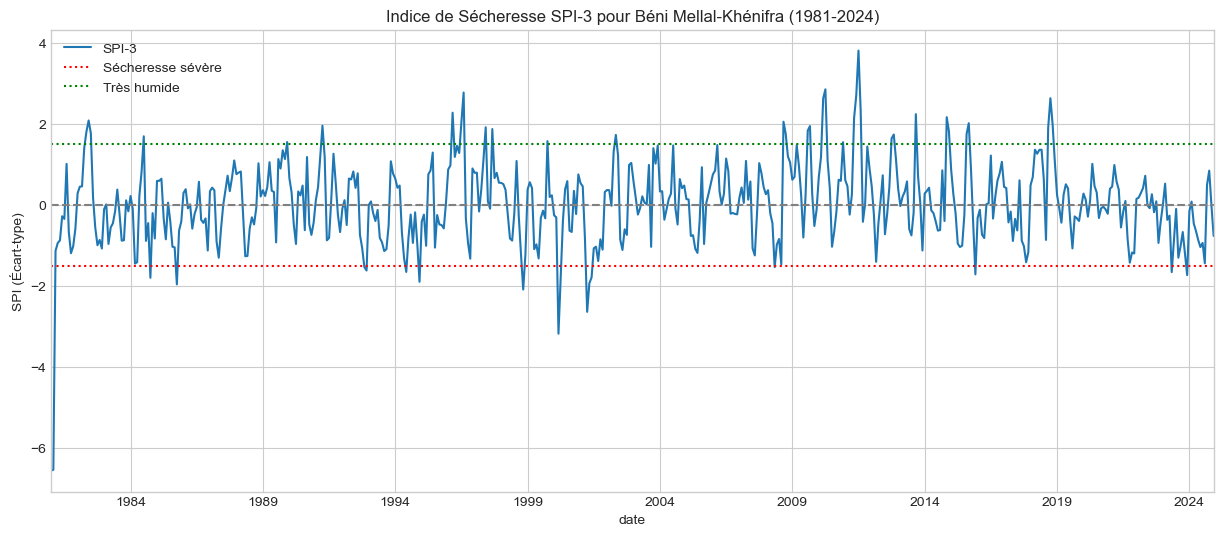


Aperçu des données finales (Pluie + SPI) :
            precip_median     spi_3     spi_6    spi_12
date                                                   
1981-01-01      32.414444 -6.556286 -6.678597 -6.773883
1981-02-01      37.984480 -6.536084 -6.699617 -6.762324
1981-03-01      36.316820 -1.134938 -6.730141 -6.765279
1981-04-01      44.214874 -0.942800 -6.720564 -6.780955
1981-05-01      18.617615 -0.877683 -6.705723 -6.775377


In [8]:
if True:
    print(f"Démarrage du Module 3, Leçon 7 : Calcul du SPI...")
    
    # 1. Charger notre CSV de précipitations
    df_precip = pd.read_csv(INPUT_CSV_PRECIP, index_col='date', parse_dates=True)
    
    # S'assurer qu'il n'y a pas de trous (très important pour le rolling)
    # 'MS' = 'Month Start'. On s'assure d'avoir une ligne pour chaque mois.
    df_precip = df_precip.asfreq('MS')
    df_precip['precip_median'] = df_precip['precip_median'].fillna(0) # Remplir les mois manquants
    
    print("Calcul du SPI-3 (sécheresse agricole court-terme)...")
    df_precip['spi_3'] = calculate_spi(df_precip['precip_median'], 3)
    
    print("Calcul du SPI-6 (sécheresse moyen-terme)...")
    df_precip['spi_6'] = calculate_spi(df_precip['precip_median'], 6)
    
    print("Calcul du SPI-12 (sécheresse long-terme, hydrologique)...")
    df_precip['spi_12'] = calculate_spi(df_precip['precip_median'], 12)

    # 2. Nettoyer les infinis (qui peuvent arriver au début)
    df_precip.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_precip = df_precip.bfill().ffill() # Remplir les NaN du début

    # 3. Sauvegarder notre travail
    df_precip.to_csv(OUTPUT_CSV_SPI)
    print(f"\nDonnées SPI sauvegardées dans : {OUTPUT_CSV_SPI}")

    # 4. Visualiser le résultat
    print("Visualisation du SPI-3...")
    plt.figure(figsize=(15, 6))
    df_precip['spi_3'].plot(label='SPI-3')
    plt.axhline(0, color='grey', linestyle='--')
    plt.axhline(-1.5, color='red', linestyle=':', label='Sécheresse sévère')
    plt.axhline(1.5, color='green', linestyle=':', label='Très humide')
    plt.title('Indice de Sécheresse SPI-3 pour Béni Mellal-Khénifra (1981-2024)')
    plt.ylabel('SPI (Écart-type)')
    plt.legend()
    plt.show()

    print("\nAperçu des données finales (Pluie + SPI) :")
    print(df_precip.head())

In [9]:
DATA_FILE = "MOD13Q1-061-Statistics.csv" 
QUALITY_STATS_FILE = "MOD13Q1-061-250m-16-days-VI-Quality-Statistics-QA.csv"
QUALITY_LOOKUP_FILE = "MOD13Q1-061-250m-16-days-VI-Quality-lookup.csv"

starting NDVI quality filtering and cleaning...
Quality lookup file read from MOD13Q1-061-250m-16-days-VI-Quality-lookup.csv...
Good quality codes identified: ['2116', '2118', '4164', '4166', '6212', '6214']
Reading quality statistics from MOD13Q1-061-250m-16-days-VI-Quality-Statistics-QA.csv...
Filtering quality stats using columns: ['2116', '2118', '4164', '4166', '6212', '6214']...
fiability ratio calculated.
Reading NDVI data from MOD13Q1-061-Statistics.csv...
NDVI raw data loaded.
Merging NDVI data with quality reliability...
Number of data points before cleaning: 572
Number of data points after cleaning: 499
Number of missing data points after cleaning: 73
Visualisation du Nettoyage...


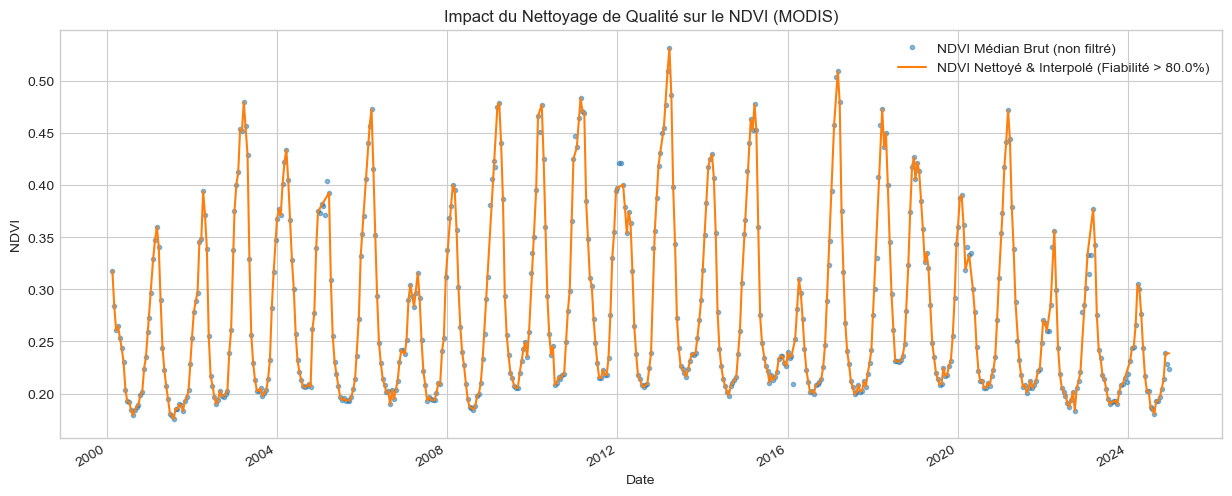

Données NDVI nettoyées et sauvegardées dans : ndvi_clean_bmk.csv


In [10]:
NDVI_CLEAN_CSV = "ndvi_clean_bmk.csv"
QUALITY_THRESHOLD = 0.80 

print('starting NDVI quality filtering and cleaning...')

print(f'Quality lookup file read from {QUALITY_LOOKUP_FILE}...')
df_lookup = pd.read_csv(QUALITY_LOOKUP_FILE)

good_categories = [
    'VI produced good quality',
    'Lower quality'  # code 2116
]

good_codes  = df_lookup[df_lookup['VI Usefulness'].isin(good_categories)]['Value'].unique()
good_codes_str = [str(c) for c in good_codes]
print(f'Good quality codes identified: {good_codes_str}')


#---------Read quality statistics file---------#
print(f'Reading quality statistics from {QUALITY_STATS_FILE}...')
df_qa = pd.read_csv(QUALITY_STATS_FILE)
df_qa['Date']  = pd.to_datetime(df_qa['Date'])
df_qa = df_qa.set_index('Date').sort_index()

df_qa.index = df_qa.index.tz_localize(None)

good_cols_present = [col for col in good_codes_str if col in df_qa.columns]
print(f'Filtering quality stats using columns: {good_cols_present}...')

df_qa['good_pixels']= df_qa[good_cols_present].sum(axis=1)

qa_pixels_cols = [col for col in df_qa.columns if col not in ['File', 'aid', 'good_pixels']]
df_qa['total_pixels'] = df_qa[qa_pixels_cols].sum(axis=1)

df_qa['reliability_ratio'] = df_qa['good_pixels'] / df_qa['total_pixels']

df_reliability = df_qa[['reliability_ratio']]
print("fiability ratio calculated.")

#---------Read NDVI data file---------#
print(f'Reading NDVI data from {DATA_FILE}...')
df_data = pd.read_csv(DATA_FILE, header=0)

df_ndvi_raw = df_data[df_data['Dataset'].str.contains('_NDVI')].copy()
df_ndvi_raw['Date'] = pd.to_datetime(df_ndvi_raw['Date'])
df_ndvi_raw = df_ndvi_raw.set_index('Date').sort_index()
df_ndvi_raw.index = df_ndvi_raw.index.tz_localize(None)
df_ndvi_raw = df_ndvi_raw[['Median']]
df_ndvi_raw.columns = ['ndvi_raw']
print("NDVI raw data loaded.")



#---------Merge NDVI with quality reliability---------#
print('Merging NDVI data with quality reliability...')
df_merged = df_ndvi_raw.join(df_reliability)
df_merged['ndvi_scaled'] = df_merged['ndvi_raw'] 

df_merged['ndvi_clean'] = np.where(
    df_merged['reliability_ratio'] >= QUALITY_THRESHOLD,
    df_merged['ndvi_scaled'],
    np.nan
)

print(f'Number of data points before cleaning: {len(df_merged)}')
print(f'Number of data points after cleaning: {df_merged["ndvi_clean"].count()}')
print(f'Number of missing data points after cleaning: {df_merged["ndvi_clean"].isnull().sum()}')

try:
    df_merged['ndvi_final'] = df_merged['ndvi_clean'].interpolate(method='time')
except ValueError:
    print("Interpolation failed, lets try linear method instead.")
    df_merged['ndvi_final'] = df_merged['ndvi_clean'].interpolate(method='linear')


df_merged['ndvi_final'] = df_merged['ndvi_final'].bfill().ffill()



print("Visualisation du Nettoyage...")
plt.figure(figsize=(15, 6))
df_merged['ndvi_scaled'].plot(style='.', alpha=0.5, label='NDVI Médian Brut (non filtré)')
df_merged['ndvi_final'].plot(style='-', label=f'NDVI Nettoyé & Interpolé (Fiabilité > {QUALITY_THRESHOLD*100}%)')
plt.title('Impact du Nettoyage de Qualité sur le NDVI (MODIS)')
plt.ylabel('NDVI')
plt.legend()
plt.show()

# 6. Sauvegarder notre travail
df_clean_to_save = df_merged[['ndvi_final']]
df_clean_to_save.to_csv(NDVI_CLEAN_CSV)
print(f"Données NDVI nettoyées et sauvegardées dans : {NDVI_CLEAN_CSV}")

In [11]:
SPI_CSV_FILE = "spi_bmk.csv"
NDVI_CSV_FILE = "ndvi_clean_bmk.csv"
MASTER_DATASET_FILE = "master_dataset_bmk.csv"

print(f'Charging of {SPI_CSV_FILE}...')
df_spi = pd.read_csv(SPI_CSV_FILE, index_col='date', parse_dates=True)

print(f'Charging of {NDVI_CSV_FILE}...')
df_ndvi = pd.read_csv(NDVI_CSV_FILE, index_col='Date', parse_dates=True)

print('\n----SPI DATA SAMPLE----')
print(df_spi.head(3))

print('\n----NDVI DATA SAMPLE-(16 days)---')
print(df_ndvi.head(3))


print('Rechanging NDVI index to monthly frequency (taking max )...')
df_ndvi_monthly = df_ndvi['ndvi_final'].resample('MS').max()
print('\n----NDVI DATA SAMPLE-(Monthly)---')
print(df_ndvi_monthly.head(3))

print('Merging SPI and NDVI ...')
df_final = df_spi.join(df_ndvi_monthly)


print(f'\n----Final Cleaned DATA-------')
df_final = df_final.dropna()
df_final.to_csv(MASTER_DATASET_FILE)
print(f'Master dataset saved to {MASTER_DATASET_FILE}.')

print(df_final.head(3))

print('\nData preparation complete.')

print('\nData infos: ')
print(df_final.info())

Charging of spi_bmk.csv...
Charging of ndvi_clean_bmk.csv...

----SPI DATA SAMPLE----
            precip_median     spi_3     spi_6    spi_12
date                                                   
1981-01-01      32.414444 -6.556286 -6.678597 -6.773883
1981-02-01      37.984480 -6.536084 -6.699617 -6.762324
1981-03-01      36.316820 -1.134938 -6.730141 -6.765279

----NDVI DATA SAMPLE-(16 days)---
            ndvi_final
Date                  
2000-02-18      0.3178
2000-03-05      0.2842
2000-03-21      0.2607
Rechanging NDVI index to monthly frequency (taking max )...

----NDVI DATA SAMPLE-(Monthly)---
Date
2000-02-01    0.3178
2000-03-01    0.2842
2000-04-01    0.2648
Freq: MS, Name: ndvi_final, dtype: float64
Merging SPI and NDVI ...

----Final Cleaned DATA-------
Master dataset saved to master_dataset_bmk.csv.
            precip_median     spi_3     spi_6    spi_12  ndvi_final
date                                                               
2000-02-01      15.669909 -0.311802 -0

In [12]:
MASTER_DATASET_FILE = "master_dataset_bmk.csv"

df= pd.read_csv(MASTER_DATASET_FILE, index_col='date', parse_dates=True)

print('-----------Master dataset loaded for analysis------------')
print('\n')
print(df.head())
print('\nstats summary:')
print(df.describe())

-----------Master dataset loaded for analysis------------


            precip_median     spi_3     spi_6    spi_12  ndvi_final
date                                                               
2000-02-01      15.669909 -0.311802 -0.001243  0.024879      0.3178
2000-03-01      26.737835 -3.179912 -0.056578 -0.053061      0.2842
2000-04-01      48.662144 -1.775440 -0.202042  0.032663      0.2648
2000-05-01      40.864150 -0.403779 -0.057742  0.080799      0.2435
2000-06-01       6.280815  0.382089 -2.182063  0.076016      0.2035

stats summary:
       precip_median       spi_3       spi_6      spi_12  ndvi_final
count     299.000000  299.000000  299.000000  299.000000  299.000000
mean       36.756379    0.107139    0.200603    0.341554    0.287068
std        31.003585    0.960559    0.817097    0.358801    0.087412
min         1.966910   -3.179912   -2.781412   -1.605195    0.178900
25%        10.239669   -0.470777   -0.119666    0.219545    0.213850
50%        30.945791    0.088492  

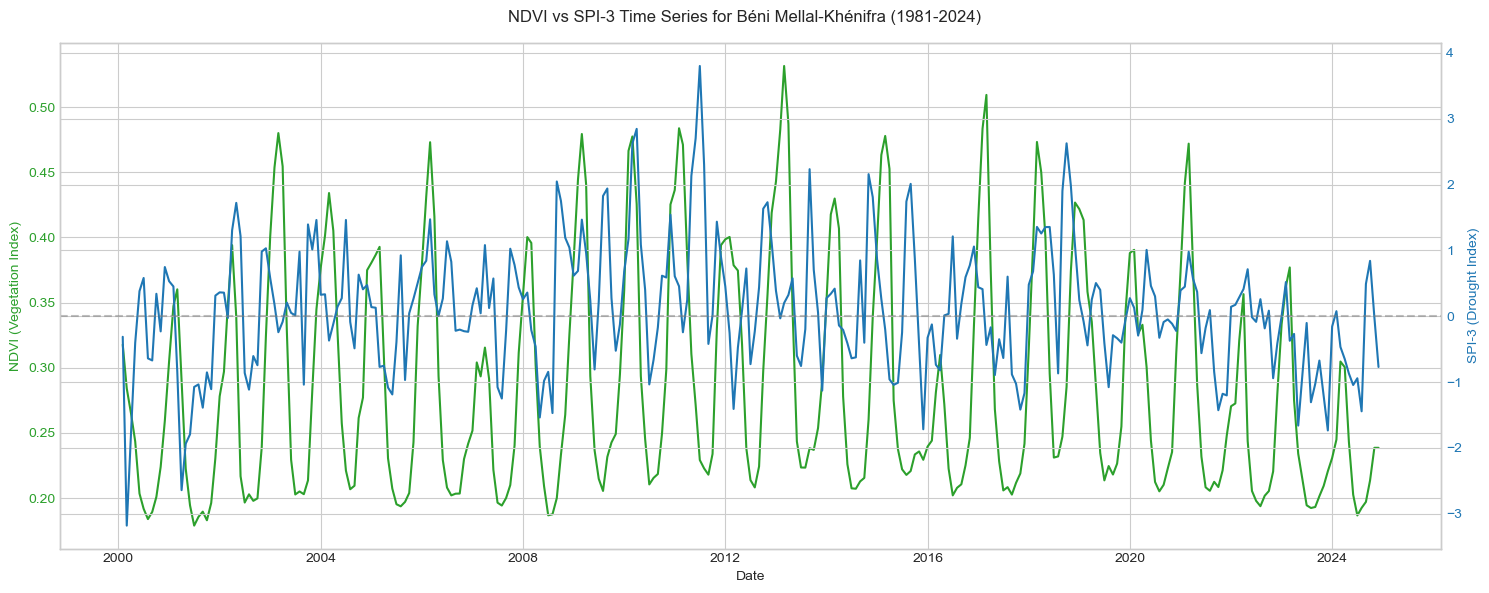

In [13]:
fig, ax1=plt.subplots(figsize=(15,6))
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI (Vegetation Index)', color=color)
ax1.plot(df.index,df['ndvi_final'], color=color, label='NDVI (Max Monthly)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('SPI-3 (Drought Index)', color=color)
ax2.plot(df.index, df['spi_3'], color=color, label='SPI-3')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='grey', linestyle='--', alpha=0.5)

fig.suptitle('NDVI vs SPI-3 Time Series for Béni Mellal-Khénifra (1981-2024)')
fig.tight_layout()
plt.show()


Lags analysis for NDVI and SPI-3...



Correlation results between NDVI and SPI lags:
ndvi_final       1.000000
precip_median    0.540104
spi_6            0.362351
spi_3            0.292922
spi_12           0.264296
dtype: float64


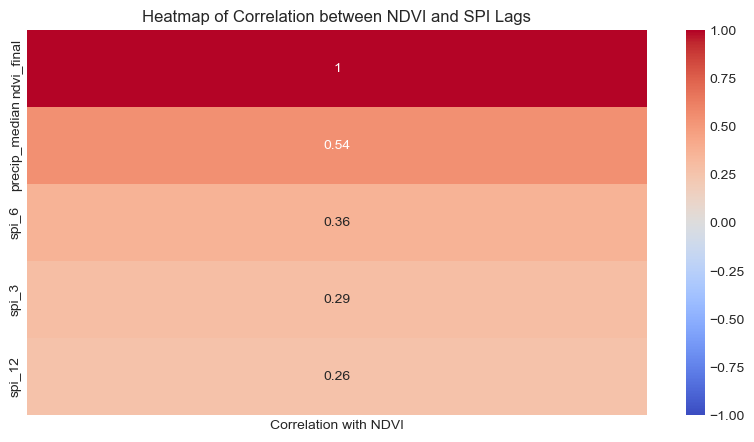

In [14]:
print('Lags analysis for NDVI and SPI-3...')
print('\n')
df_lags  = df.copy()
df_lags['spi_3_lag0'] = df['spi_3']           # SPI du mois M (temps 0)
df_lags['spi_3_lag1'] = df['spi_3'].shift(1) # SPI du mois M-1
df_lags['spi_3_lag2'] = df['spi_3'].shift(2) # SPI du mois M-2
df_lags['spi_3_lag3'] = df['spi_3'].shift(3) # SPI du mois M-3
df_lags['spi_6_lag3'] = df['spi_6'].shift(3) # Essayons aussi un autre indice
df_lags['spi_12_lag6'] = df['spi_12'].shift(6) # Et un autre

df_lags_target = df_lags[['ndvi_final']]

df_lags = df.dropna()
df_lags_target = df_lags_target.loc[df_lags.index]

corr_matrix = df_lags.corrwith(df_lags_target['ndvi_final']).sort_values(ascending=False)

print('\nCorrelation results between NDVI and SPI lags:')
print(corr_matrix)

plt.figure(figsize=(10,5))
heatmap_data = corr_matrix.to_frame(name="Correlation with NDVI")
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between NDVI and SPI Lags')
plt.show()


Visualisation 4 : Matrice de Corrélation Complète...


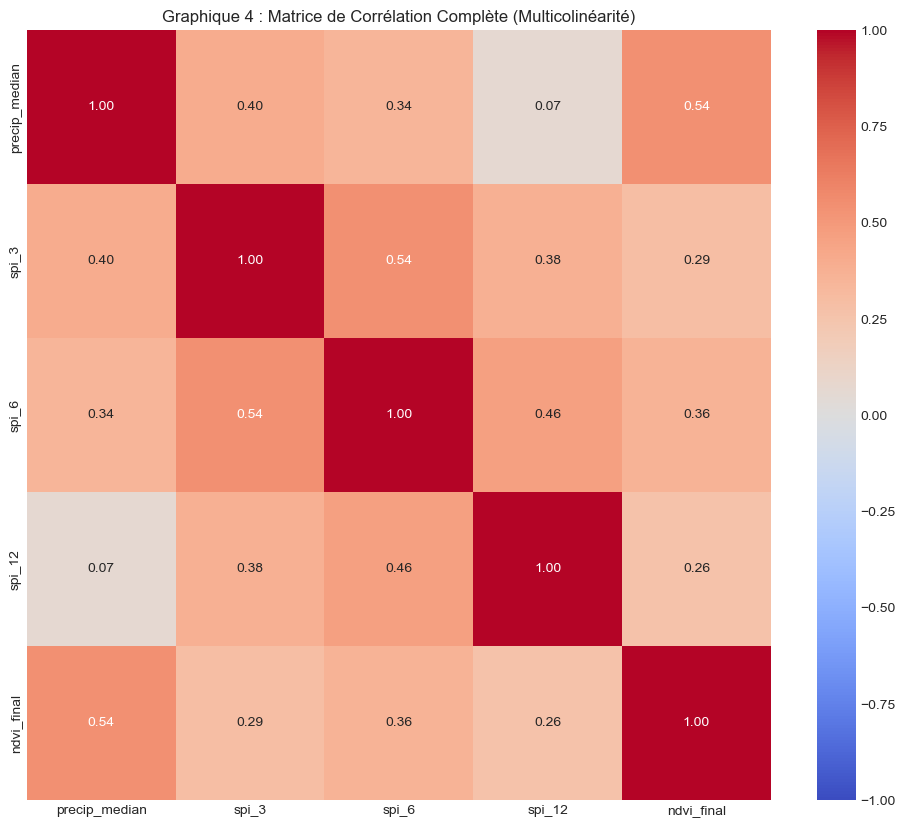

In [15]:
# --- Code optionnel pour la matrice de corrélation complète ---
print("\nVisualisation 4 : Matrice de Corrélation Complète...")

# 1. Calculer la matrice carrée
full_corr_matrix = df_lags.corr()

# 2. La visualiser
plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Graphique 4 : Matrice de Corrélation Complète (Multicolinéarité)')
plt.show()

## Forcasting with Neural Nets 

In [16]:
MASTER_DATASET_FILE = "master_dataset_bmk.csv"

df=pd.read_csv(MASTER_DATASET_FILE, index_col='date', parse_dates=True)
print('Master datset loaded for forecasting...')
print(df.head())

print('\nCreating predictors (X) & target (y) variables...')
df_model = df.copy()
df_model['y_target_ndvi'] = df['ndvi_final']


df_model['X_ndvi_lags1'] = df['ndvi_final'].shift(1)  #NDVI month M-1
df_model['X_spi3_lag1'] = df['spi_3'].shift(1)  # SPI month M-1
df_model['X_spi3_lag2'] = df['spi_3'].shift(2)  # SPI month M-2
df_model['X_spi6_lag3'] = df['spi_6'].shift(3)  # SPI-6 month M-3


print('\nVisulization of prepared dataset for modeling:\n')
print(df_model.head())

Master datset loaded for forecasting...
            precip_median     spi_3     spi_6    spi_12  ndvi_final
date                                                               
2000-02-01      15.669909 -0.311802 -0.001243  0.024879      0.3178
2000-03-01      26.737835 -3.179912 -0.056578 -0.053061      0.2842
2000-04-01      48.662144 -1.775440 -0.202042  0.032663      0.2648
2000-05-01      40.864150 -0.403779 -0.057742  0.080799      0.2435
2000-06-01       6.280815  0.382089 -2.182063  0.076016      0.2035

Creating predictors (X) & target (y) variables...

Visulization of prepared dataset for modeling:

            precip_median     spi_3     spi_6    spi_12  ndvi_final  \
date                                                                  
2000-02-01      15.669909 -0.311802 -0.001243  0.024879      0.3178   
2000-03-01      26.737835 -3.179912 -0.056578 -0.053061      0.2842   
2000-04-01      48.662144 -1.775440 -0.202042  0.032663      0.2648   
2000-05-01      40.864150 -0.

In [17]:
print('\nDropping NaN values')
print(f'Number of rows before dropping NaNs: {len(df_model)}')
df_model  = df_model.dropna()
print(f'\nLength after dropping NaNs: {len(df_model)}')
print('\n')
print(df_model.head())


Dropping NaN values
Number of rows before dropping NaNs: 299

Length after dropping NaNs: 296


            precip_median     spi_3     spi_6    spi_12  ndvi_final  \
date                                                                  
2000-05-01      40.864150 -0.403779 -0.057742  0.080799      0.2435   
2000-06-01       6.280815  0.382089 -2.182063  0.076016      0.2035   
2000-07-01       1.998351  0.582006 -1.351537  0.073329      0.1918   
2000-08-01       6.217215 -0.639299 -0.478076  0.075747      0.1839   
2000-09-01       8.088072 -0.670814  0.166349  0.069153      0.1894   

            y_target_ndvi  X_ndvi_lags1  X_spi3_lag1  X_spi3_lag2  X_spi6_lag3  
date                                                                            
2000-05-01         0.2435        0.2648    -1.775440    -3.179912    -0.001243  
2000-06-01         0.2035        0.2435    -0.403779    -1.775440    -0.056578  
2000-07-01         0.1918        0.2035     0.382089    -0.403779    -0.202042  


In [18]:
features = [col for col in df_model.columns if col.startswith('X_')]
target = 'y_target_ndvi'

X= df_model[features]
y = df_model[target]

print('\nPredictors (X):')
print(X.head())
print('\nTarget (y):')
print(y.head())


Predictors (X):
            X_ndvi_lags1  X_spi3_lag1  X_spi3_lag2  X_spi6_lag3
date                                                           
2000-05-01        0.2648    -1.775440    -3.179912    -0.001243
2000-06-01        0.2435    -0.403779    -1.775440    -0.056578
2000-07-01        0.2035     0.382089    -0.403779    -0.202042
2000-08-01        0.1918     0.582006     0.382089    -0.057742
2000-09-01        0.1839    -0.639299     0.582006    -2.182063

Target (y):
date
2000-05-01    0.2435
2000-06-01    0.2035
2000-07-01    0.1918
2000-08-01    0.1839
2000-09-01    0.1894
Name: y_target_ndvi, dtype: float64


In [19]:
# Scaling 

scaler_X= MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

print('\nScaled Predictors (X_scaled):')
print(X_scaled[:5])
print('\nScaled Target (y_scaled):')
print(y_scaled[:5])


Scaled Predictors (X_scaled):
[[0.24354976 0.13437741 0.         0.49543123]
 [0.18315849 0.34724656 0.20114847 0.48557036]
 [0.06974766 0.46920612 0.39759765 0.45964838]
 [0.03657499 0.5002313  0.51014968 0.4853629 ]
 [0.01417635 0.31069599 0.53878169 0.10680517]]

Scaled Target (y_scaled):
[[0.18315849]
 [0.06974766]
 [0.03657499]
 [0.01417635]
 [0.02977034]]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

print('Len of training set:', len(X_train))
print('Len of testing set:', len(X_test))

Len of training set: 236
Len of testing set: 60


In [21]:
# model construction 

n_features  = X_train.shape[1]

model=Sequential()
model.add(Dense(32, activation='relu', input_shape=(n_features,)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
print('\nModel compiled with Adam optimizer and MSE loss function.')


Model compiled with Adam optimizer and MSE loss function.


In [23]:
# model training

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Let's gooo (: 

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)
print('\nModel training complete.')

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.2436 - val_loss: 0.0592
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1188 - val_loss: 0.0434
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0706 - val_loss: 0.0377
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0527 - val_loss: 0.0285
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0467 - val_loss: 0.0232
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0472 - val_loss: 0.0193
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0311 - val_loss: 0.0162
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0322 - val_loss: 0.0147
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0315 - val_loss: 0.0137
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0301 - val_loss: 0.0133
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0273 - val_loss: 0.0134
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

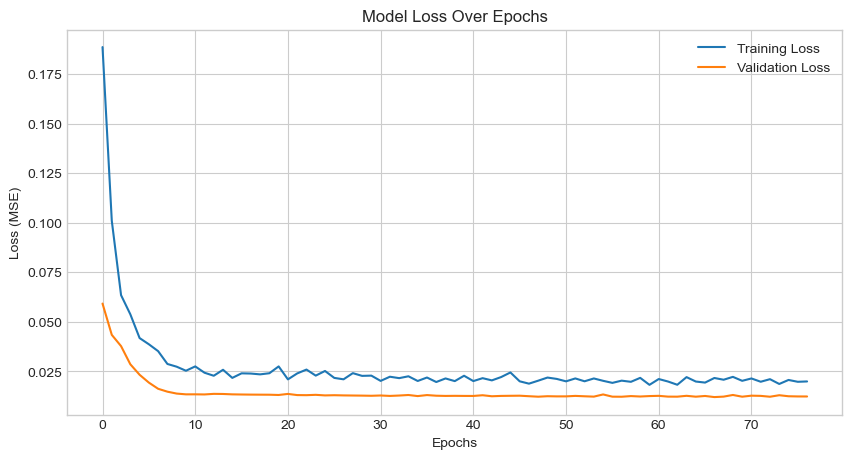

In [24]:
history_df= pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [25]:
print('\nEvaluating model performance on test set')
y_pred_scaled  = model.predict(X_test)
print('\nNormalized predictions obtained:\n')
print(y_pred_scaled[:5].reshape(-1))


Evaluating model performance on test set
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

Normalized predictions obtained:

[0.4451715  0.5311381  0.5410431  0.36913928 0.40036973]


In [26]:
# Unscale predictions

y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

print(f'Prediction example: {y_pred_unscaled[0]}\n')

print(f'Reality example: {y_test_unscaled[0].reshape(-1)}')

Prediction example: [0.335912]

Reality example: [0.3881]


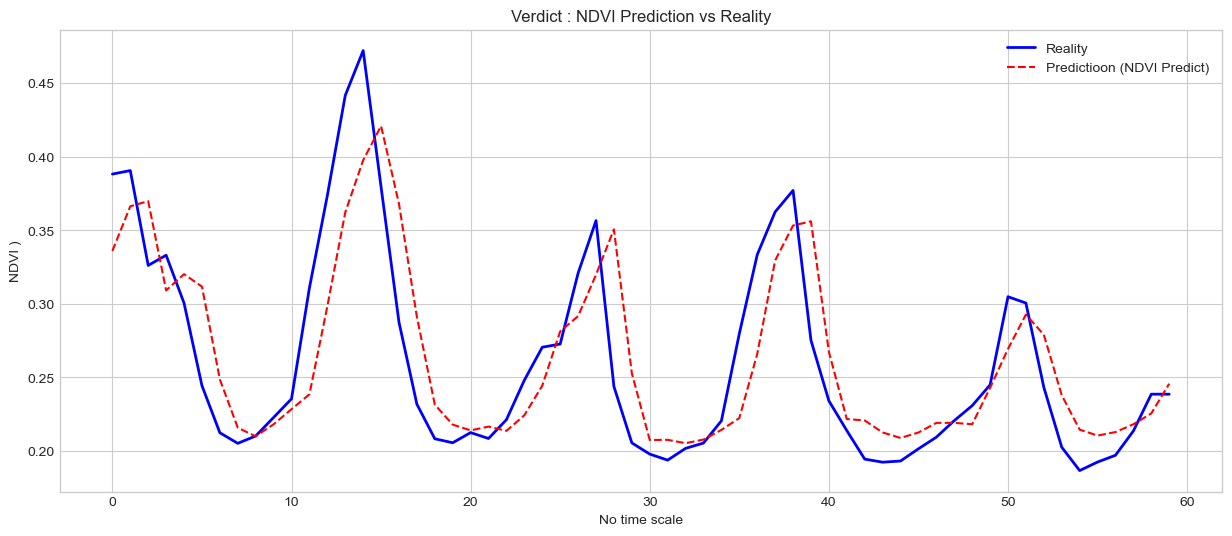

In [27]:
# Verdict visualization

plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label='Reality', color='blue', linewidth=2)
plt.plot(y_pred_unscaled, label='Predictioon (NDVI Predict)', color='red', linestyle='--')
plt.title('Verdict : NDVI Prediction vs Reality')
plt.ylabel('NDVI )')
plt.xlabel('No time scale')
plt.legend()
plt.show()

In [28]:
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
print(f'RMSE : {rmse}')
print(f"Échelle du NDVI (Min) : {y_test_unscaled.min():.4f}")
print(f"Échelle du NDVI (Max) : {y_test_unscaled.max():.4f}")
print(f"Échelle du NDVI (avg) : {y_test_unscaled.mean():.4f}")

RMSE : 0.0385837727926503
Échelle du NDVI (Min) : 0.1867
Échelle du NDVI (Max) : 0.4720
Échelle du NDVI (avg) : 0.2607


In [44]:
MASTER_DATASET_FILE = "master_dataset_bmk.csv"
df_full = pd.read_csv(MASTER_DATASET_FILE, index_col='date', parse_dates=True)


df_features = pd.DataFrame(df_full.index)
df_features['X_ndvi_lag1'] = df_full['ndvi_final'].shift(1)
df_features['X_spi3_lag1'] = df_full['spi_3'].shift(1)
df_features['X_spi3_lag2'] = df_full['spi_3'].shift(2)
df_features['X_spi6_lag3'] = df_full['spi_6'].shift(3)

#

In [53]:
MASTER_DATASET_FILE = "master_dataset_bmk.csv"
print(f"Chargement de {MASTER_DATASET_FILE}...")
df_full = pd.read_csv(MASTER_DATASET_FILE, index_col='date', parse_dates=True)

# --- DEBUG 1 ---
print(f"DEBUG : Taille de df_full (Master Dataset) : {len(df_full)} lignes")
if len(df_full) == 0:
    print("ERREUR : Votre master_dataset_bmk.csv est VIDE. Veuillez ré-exécuter la Leçon 9 (Fusion).")
else:
    # --- Continuer ---
    df_features = pd.DataFrame(index=df_full.index)
    # Assurez-vous que le nom de colonne 'ndvi_max_monthly' est correct !
    df_features['X_ndvi_lag1'] = df_full['ndvi_final'].shift(1)
    df_features['X_spi3_lag1'] = df_full['spi_3'].shift(1)
    df_features['X_spi3_lag2'] = df_full['spi_3'].shift(2)
    df_features['X_spi6_lag3'] = df_full['spi_6'].shift(3)

    # --- DEBUG 2 ---
    df_features_dropped = df_features.dropna()
    print(f"DEBUG : Taille de df_features après .dropna() : {len(df_features_dropped)} lignes")

    if len(df_features_dropped) == 0:
        print("ERREUR : df_features est vide après dropna(). C'est très étrange.")
        print("Vérifiez les noms de colonnes dans master_dataset_bmk.csv.")
        print("Colonnes disponibles : ", list(df_full.columns))
    else:
        # --- Continuer (Cette partie devrait maintenant fonctionner) ---
        last_known_data = df_features_dropped.iloc[[-1]] 
        print("Indices utilisés pour la prédiction (données les plus récentes) :")
        print(last_known_data)

Chargement de master_dataset_bmk.csv...
DEBUG : Taille de df_full (Master Dataset) : 299 lignes
DEBUG : Taille de df_features après .dropna() : 296 lignes
Indices utilisés pour la prédiction (données les plus récentes) :
            X_ndvi_lag1  X_spi3_lag1  X_spi3_lag2  X_spi6_lag3
date                                                          
2024-12-01       0.2386    -0.011855     0.841639     -0.83818


In [56]:
print('Model prediction for next month NDVI...')

prediction_scale = model.predict(last_known_data)
print(prediction_scale)

Model prediction for next month NDVI...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[0.31981435]]


In [58]:
# Unscale prediction
prediction_unscaled = scaler_y.inverse_transform(prediction_scale)
print('Model prediction, real NDVI value for next month:\n')
print(prediction_unscaled)

Model prediction, real NDVI value for next month:

[[0.29169852]]


In [60]:
# Final verdict 
predicted_ndvi = prediction_unscaled[0][0]

last_date = last_known_data.index.strftime('%Y-%m-%d')[0]

print(f"En se basant sur les données s'arrêtant à : {last_date}")
print(f"Le NDVI prédit pour le mois prochain est : {predicted_ndvi:.4f}")


En se basant sur les données s'arrêtant à : 2024-12-01
Le NDVI prédit pour le mois prochain est : 0.2917
